In [44]:
# import requests
import re
from bs4 import BeautifulSoup 
import pandas as pd
import lxml

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import requests
import wget
import glob
import time
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

import gpxpy 
import gpxpy.gpx 
import glob


# Read Me

Planning a winter time hikes can be complicated in Switzerland. Sometimes hiking in the snow is an exciting adventure, but it can also be an unexpected surprise. There is no shortage of trail databases that contain information about how long or how difficult a trail is, however finding up to date information about snowfall data on these trails can be tedious. This notebook solves the snowline problem by scraping GPX data from bergfex.com and **INSERT SNOWDATA WEBSITE**. 

Weather GPS data is obtained from multiple weather towers across Switzerland that publicly provide current weather data. Since these towers are located in a specific latitude and longitude, an approximate chance of snowfall was assumed based on the distance from the tower and altitude. If a trail is within a certain distance from a tower, and is also at a certain altitude then it will be tagged with a snow alert. This was implemented by using the nearest neighbor algorithm, which finds the closest hiking trails to a tower that has reported snow.

# Comments / Changes SD: 
- some spelling mistakes
- heading nummeration and some of the structure
- some comments where I felt appropriate

# Questions SD:
- did we use KNN algorithm? I don't think so, but wanted to check with you. If not we should remove in comment in "read me".
- did we filter for Hikes only? I don't think so, so I removed the corresponding sentence in the bar chart description
- I'm not sure I understand the comment in 3.5. I believe most of the trails are below 1500m and below 20km.

# Add / change SD:
- "Things to learn in this tutorial": Webscraping from a static page, Basic Data Cleaning, Basic plots, GPX coordinates, KML coordinates (add both? describe the differences?)
- change the "hikes" DF --- missleading as it contains all type of activities
- Include the ID in the main DF
- add more sophisticated correlation checks (correlation matrix)
- Add different colours of the line plot in 3.5
- explain why weighted ave lenght and norm. w.a. is needed

# 1  Data scraping and cleaning

Prepare to scrape the Bergfex.com website in order to create Pandas dataframes that contain important information about each trail. This code uses BeautifulSoup to parse the html tags into json, which is easier to work with. A for-loop iterates over each html tag and adds the corresponding information into empty lists. 

### 1.1 Scrape all the information (basic and more complicated)

In [5]:
title = []  # Title of the tour
difficulty = []  # difficulty (easy, medium, hard)
sport = []  # Sport type (hiking, sledging, snowshoe...)
length = []  # length in km
time_list = []  # tour time in hours:minutes
climb = []  # positive elevation climb in m
minmax = []  # minimum and maximum altitude of the tour in m
technique = []  # technique difficulty ratings (out of 6)
fitness = []  # fitness difficulty ratings (out of 6)
total_title = [] # will help extracting the ID of the tour

# all ratings are stored together so we will need this along the way:
rating = []  # list to store technique and fitness rating info

In [6]:
# looping over the 10 first pages of Bergfex
# each separate tour on the page is framed by a div tag with 'touren-details'

page_number = 20  # number of pages we want to scap through

for p in range(1, (page_number+1)):
    base_link = 'https://www.bergfex.com/sommer/bern-region/touren/?isAjax=1&page='
    link = base_link+str(p)  # going over p pages with numbers appended to the base link
    page = requests.get(link, timeout=5)
    print("scraped page", p)
    soup = BeautifulSoup(page.content, "html.parser")  # bs4.BeautifulSoup object
    tours = soup.findAll('div', {'class': 'touren-detail'})  # checks for the separate tours on the page

# For each page, we loop over each tour and fill our lists with info     
    for i in range(0,len(tours)):
        tour_1 = tours[i] # tour iterating over the 20 tours of the page

        tour_title = tour_1.findAll('a' ) # this gets the title out
        title.append([info.get_text().strip() for info in tour_title])
        total_title.append(tour_title) 
        # this gets the full tour-title information including the ID, will need to be processed further later on
        
        tour_diff = tour_1.findAll('span', {'class': 'tour-difficulty'}) #tour level difficulty
        difficulty.append([info.get_text().strip() for info in tour_diff])

        tour_type = tour_1.findAll('span', {'class': 'tour-type'}) # putting type into sports (should all be hiking)
        sport.append([info.get_text().strip() for info in tour_type])

        tour_stats = tour_1.findAll('div', {'class': 'tour-stats'}) # stats has 4 info binned together
        stat_text = [info.get_text().strip() for info in tour_stats]
        length.append(stat_text[0])
        time_list.append(stat_text[1])
        climb.append(stat_text[2])
        minmax.append(stat_text[3])
        
        tour_rating = tour_1.find_all("div", {'class': 'tour-rating'}) # getting the rating data 
        rating.append([info for info in tour_rating])   # it's a class name so we can't get_text.

scraped page 1
scraped page 2
scraped page 3
scraped page 4
scraped page 5
scraped page 6
scraped page 7
scraped page 8
scraped page 9
scraped page 10
scraped page 11
scraped page 12
scraped page 13
scraped page 14
scraped page 15
scraped page 16
scraped page 17
scraped page 18
scraped page 19
scraped page 20


In [7]:
print("number of tours collected:", len(title))

number of tours collected: 400


### 1.2 Extracting embedded HTML tags: <a href="" 
Each trail name and ID was used in Bergfex's URL. Using the trail ID in the dataframe will provide a unique ID to use later in the analysis. However, those two data points are embedded deeper in the html code. The below codes shows how to extract the datapoints into a dataframe.

In [8]:
# Extracting the ID via the URL
links_title = []

for i in total_title:
    i = str(i)
    i = i.strip('[]')
    links_title.append(i)

<a class="h2" href="/sommer/bern-region/touren/wanderung/50210,aus-der-alpenstadt-an-den-fuss-des-stockhorns/" title="Aus der Alpenstadt an den Fuss des Stockhorns">Aus der Alpenstadt an den Fuss des Stockhorns</a>
<a class="h2" href="/sommer/bern-region/touren/wanderung/110723,hohtuerli--bluemlisalphuette/" title="Hohtürli – Blümlisalphütte">Hohtürli – Blümlisalphütte</a>
<a class="h2" href="/sommer/bern-region/touren/themenweg/658328,durchs-jahr-wandern--wiehnachtswaeg-aeschi/" title="Durchs Jahr wandern - Wiehnachtswäg Aeschi">Durchs Jahr wandern - Wiehnachtswäg Aeschi</a>
<a class="h2" href="/sommer/bern-region/touren/wanderung/50926,frei-wie-ein-vogel-ueber-der-lenk/" title="Frei wie ein Vogel über der Lenk">Frei wie ein Vogel über der Lenk</a>
<a class="h2" href="/sommer/bern-region/touren/wanderung/98262,dem-kandersteger-bergsturz-entgegen/" title="Dem Kandersteger Bergsturz entgegen">Dem Kandersteger Bergsturz entgegen</a>
<a class="h2" href="/sommer/bern-region/touren/wanderun

In order to make the trail ID usable it needs to be cleaned up and converted into a string

In [13]:
# Extracting ID

id_df3 = pd.DataFrame(links_title)
id_df2 = id_df3[0].str.split(' ',expand = True)
id_df1 = id_df2[2].str.split(',',expand = True)
id_df = id_df1[0].str.split('/',expand = True)

In [1]:
# from this format:

pd.options.display.max_colwidth = 100
id_df3.head()

NameError: name 'pd' is not defined

In [ ]:
# to this format:
id_df.head()

### 1.3 Extracting embedded HTML tags: <Div class=""
The HTML tags for the fitness and technique ratings were embedded within Div class tags; they are extracted using a for loop and then stripped of unecessary characeters. 
- Convert the tour rating tag into a string
- Strip away unecessary characters 
- Split into lists which look like rating_list[Technique, Fitness, Technique, Fitness]
- Finally, convert into seperate lists for Technique and Fitness

In [14]:
# rating[0]     # View the emmbedded DIV tag
tour_rating_str = str(rating)
rating_all_short = tour_rating_str.replace(
    '<div class="tour-rating">\n<div class="tour-rating-label">Technique</div>\n
    <div class="rating-circles rating-max6"><div class="',''
).replace(
    '<div class="tour-rating">\n<div class="tour-rating-label">Fitness</div>\n
    <div class="rating-circles rating-max6"><div class="','').replace('"></div></div>\n</div>',"")
rating_even_shorter = rating_all_short.replace('[','').replace(']','')
rating_list = rating_even_shorter.split(", ")

for i in range(0,(len(rating_list))):
    if i == 0:
        technique.append(rating_list[i]) # add first and second elements to technique list
    elif i % 2 == 0:
        technique.append(rating_list[i]) # then every second item as well
    else:
        fitness.append(rating_list[i]) # the other appended to fitness list

### 1.4  Create dataframe for extracted elements

This dataframe is not in the final stage yet as there are still extra brackets, the minimum and maximum elevation are still in one column, and units must be stripped away

In [15]:
hikes_df = pd.DataFrame(
    {'title': title,
     'difficulty': difficulty,
     'sport': sport,
     'length': length,
     'time': time_list,
     'climb': climb,
     'minmax': minmax,
     'technique': technique,
     'fitness': fitness
    })

 # Comment SD:  Add 'ID' here into base DF as well?

In [16]:
hikes_df

,title,difficulty,sport,length,time,climb,minmax,technique,fitness
0,[Aus der Alpenstadt an den Fuss des Stockhorns],[easy],[Hiking],9.8km,02:35h,230hm,559 - 729m,rating-2,rating-2
1,[Hohtürli – Blümlisalphütte],[medium],[Hiking],15.58km,07:45h,"1,682hm","1,173 - 2,838m",rating-4,rating-4
2,[Durchs Jahr wandern - Wiehnachtswäg Aeschi],[easy],[Thematic route],1.86km,01:00h,40hm,934 - 964m,rating-1,rating-1
3,[Frei wie ein Vogel über der Lenk],[difficult],[Hiking],13.26km,05:40h,"1,300hm","1,014 - 2,079m",rating-5,rating-5
4,[Dem Kandersteger Bergsturz entgegen],[medium],[Hiking],10.3km,03:10h,521hm,"807 - 1,317m",rating-3,rating-2
...,...,...,...,...,...,...,...,...,...
395,[Über die Greberegg zum Pochtenfall],[medium],[Hiking],12.97km,04:50h,766hm,"979 - 1,650m",rating-3,rating-3
396,[Über den Frienisberg],[easy],[Hiking],11.1km,03:00h,280hm,448 - 796m,rating-2,rating-2
397,[Lauenensee - Geltenhütte SAC - Lauenensee],[medium],[Hiking],8.01km,04:00h,678hm,"1,378 - 2,056m",rating-3,rating-4
398,[Vom Ruedihus zur Doldenhornhütte SAC],[medium],[Hiking],10.79km,04:40h,961hm,"1,172 - 1,905m",rating-4,rating-4


# 2  Data Cleaning

As mentioned above, the dataframe still needs to be cleaned up. 

### 2.1 Clean Categorical Data
- Convert columns to strings
- Remove brackets that are in the first 3 columnns
- Remove extra whitespace

In [17]:
# Converting the text columns to strings for easier handling later
hikes_df[['title', 'difficulty', 'sport']] = hikes_df[['title', 'difficulty', 'sport']].astype('str')

# Removing the brackets
hikes_df['title'] = hikes_df['title'].str.strip('[]')
hikes_df['difficulty'] = hikes_df['difficulty'].str.strip('[]')
hikes_df['sport'] = hikes_df['sport'].str.strip('[]')

# Remove extra whitespace
hikes_df['title'] = pd.Series(hikes_df['title']).str.replace("'", '')
hikes_df['difficulty'] = pd.Series(hikes_df['difficulty']).str.replace("'", '')
hikes_df['sport'] = pd.Series(hikes_df['sport']).str.replace("'", '')


# Remove units (km, m, h, hm, m)
hikes_df['length'] = pd.Series(hikes_df['length']).str.replace("km", '')
hikes_df['time'] = pd.Series(hikes_df['time']).str.replace("h", '')
hikes_df['climb'] = pd.Series(hikes_df['climb']).str.replace("hm", '')
hikes_df['minmax'] = pd.Series(hikes_df['minmax']).str.replace("m", '')

# Seperate the minmax altitude into a min column and a max column
hikes_df[['min','max']] = hikes_df['minmax'].str.split("-",expand=True)
hikes_df = hikes_df.drop(columns=['minmax'])

# Organize the dataframe columns
hikes_df = hikes_df[['title', 'difficulty', 'sport', 'length', 'time', 'climb', 'min', 'max', 'technique', 'fitness']]

In [18]:
hikes_df

,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,Aus der Alpenstadt an den Fuss des Stockhorns,easy,Hiking,9.8,02:35,230,559,729,rating-2,rating-2
1,Hohtürli – Blümlisalphütte,medium,Hiking,15.58,07:45,"1,682","1,173","2,838",rating-4,rating-4
2,Durchs Jahr wandern - Wiehnachtswäg Aeschi,easy,Thematic route,1.86,01:00,40,934,964,rating-1,rating-1
3,Frei wie ein Vogel über der Lenk,difficult,Hiking,13.26,05:40,"1,300","1,014","2,079",rating-5,rating-5
4,Dem Kandersteger Bergsturz entgegen,medium,Hiking,10.3,03:10,521,807,"1,317",rating-3,rating-2
...,...,...,...,...,...,...,...,...,...,...
395,Über die Greberegg zum Pochtenfall,medium,Hiking,12.97,04:50,766,979,"1,650",rating-3,rating-3
396,Über den Frienisberg,easy,Hiking,11.1,03:00,280,448,796,rating-2,rating-2
397,Lauenensee - Geltenhütte SAC - Lauenensee,medium,Hiking,8.01,04:00,678,"1,378","2,056",rating-3,rating-4
398,Vom Ruedihus zur Doldenhornhütte SAC,medium,Hiking,10.79,04:40,961,"1,172","1,905",rating-4,rating-4


### 2.2 Clean Numerical Data

In order to normalize data for analysis, we must preform the following steps:

-  Replace missing numerical data with 0
-  Remove commas
-  Remove "-"
-  Remove unnecessary words ("rating-"


In [19]:
hikes_df['length'] = (hikes_df['length']).astype(float)

hikes_df['climb'] = pd.Series(hikes_df['climb']).str.replace(",", '') 
hikes_df['climb'] = pd.Series(hikes_df['climb']).str.replace("-", '0') 
hikes_df['climb'] = (hikes_df['climb']).astype(int)

hikes_df['min'] = pd.Series(hikes_df['min']).str.replace(",", '') 
hikes_df['min'] = (hikes_df['min']).astype(int)
hikes_df['max'] = pd.Series(hikes_df['max']).str.replace(",", '') 
hikes_df['max'] = (hikes_df['max']).astype(int)

hikes_df['technique'] = pd.Series(hikes_df['technique']).str.replace("rating-", '')
hikes_df['technique'] = pd.to_numeric(hikes_df['technique'], errors='coerce')
hikes_df['technique'] = pd.Series(hikes_df['technique']).replace(np.nan, 0, regex = True)
hikes_df['technique'] = pd.Series(hikes_df['technique']).astype('int')

hikes_df['fitness'] = pd.Series(hikes_df['fitness']).str.replace("rating-", '')
hikes_df['fitness'] = pd.to_numeric(hikes_df['fitness'], errors='coerce')
hikes_df['fitness'] = pd.Series(hikes_df['fitness']).replace(np.nan, 0, regex = True)
hikes_df['fitness'] = hikes_df['fitness'].astype('int')

### 2.3 Clean Time Data
Some of the hikes can register times >24 hours, and this causes Pandas to throw an error. This is handled by using Try/Except

In [20]:
# convert times to time objects
try:
    hikes_df['time'] = pd.to_datetime(hikes_df['time'], format='%H:%M').dt.time_list
except ValueError:
    pass

### 2.4 Final check of DataFrame
Double check for null values. It looks pretty good!  Now it's time to start analysis. 

In [ ]:
hikes_df

In [22]:
hikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       400 non-null    object 
 1   difficulty  400 non-null    object 
 2   sport       400 non-null    object 
 3   length      400 non-null    float64
 4   time        400 non-null    object 
 5   climb       400 non-null    int64  
 6   min         400 non-null    int64  
 7   max         400 non-null    int64  
 8   technique   400 non-null    int64  
 9   fitness     400 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 31.4+ KB


### 2.5 Write CSV

Now that the data has been cleaned properly, let's save the dataframe to a CSV for future use and hash out the scraping code in 1.1. Otherwise if you rerun the Kernel too often, there is a risk of being blocked by the website.

In [101]:
hikes_df.to_csv("hikes.csv", index=False)

# 3  Initial Data Analysis

Before moving onto combining weather data with hiking trails, lets do some preliminary data analysis to see what we are working with.

In [55]:
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 10, 8

### 3.1 Data Exploration 

We will begin the data analysis by data exploration. By creating different data frames and removing activities with little data to improve visualizations we can get a better idea of what types of trails we are working with. 

Here we can see that cycling, racing, and long-distance walking are much longer than the other types of trails. Another helpful tool this DataFrame provides is that we can now view the least used trail types in the dataset. These are going to be removed for the next few analysis steps so it's easier to look at the interesting trail statistics.

In [78]:
# Creating a df for "Number of entries by sport type" + average tour length
sporttype = hikes_df.groupby('sport') \
       .agg({'sport':'count', 'length':'mean'}) \
       .rename(columns={'sport':'count','length':'average_length'}) \
       .reset_index() \
       .sort_values(by=['average_length'])
sporttype

,sport,count,average_length
3,Nordic Walking,2,4.880000
8,Snowshoe,14,5.042143
12,Winter hiking,18,5.562778
6,Ski tour,1,6.110000
7,Sledge,3,6.146667
9,Thematic route,39,7.432821
1,Hiking,275,10.958509
11,Via ferrata,2,13.650000
4,Pilgrimage,9,17.458889
2,Mountainbike,14,22.581429


### 3.2 Focus on the most relevant activities
Remove the activities, which have less than 10 entries.

In [79]:
hikes_analysis = hikes_df.groupby("sport").filter(lambda x: len(x) > 10)
hikes_analysis.groupby(['sport']).size()

sport
Cycling            13
Hiking            275
Mountainbike       14
Snowshoe           14
Thematic route     39
Winter hiking      18
dtype: int64

### 3.3 Bar Chart Visualization
Now that the activities with little entries are removed, a barchart of the sport types is much more readable. We can see that the most popular activity on our list of trails is hiking with more than 250 entries.

Text(0, 0.5, 'Count')

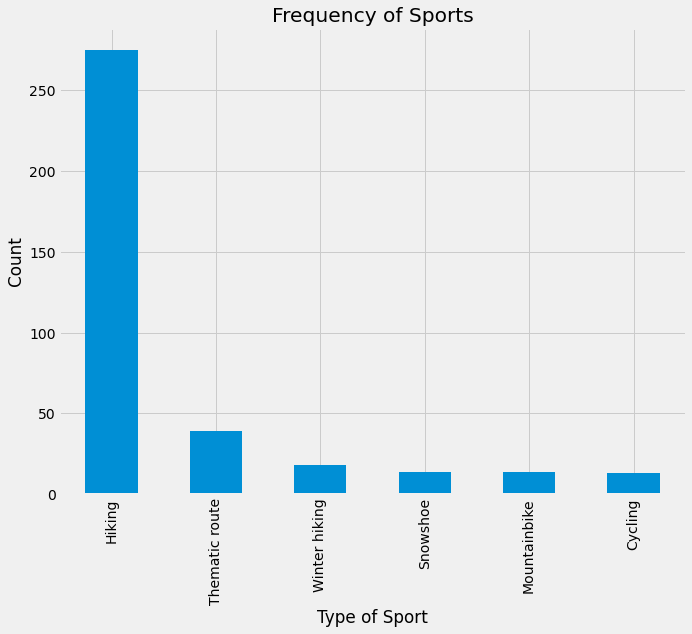

In [75]:
ax = hikes_analysis['sport'].value_counts().plot(kind='bar')
plt.title('Frequency of Sports')
plt.xlabel('Type of Sport')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

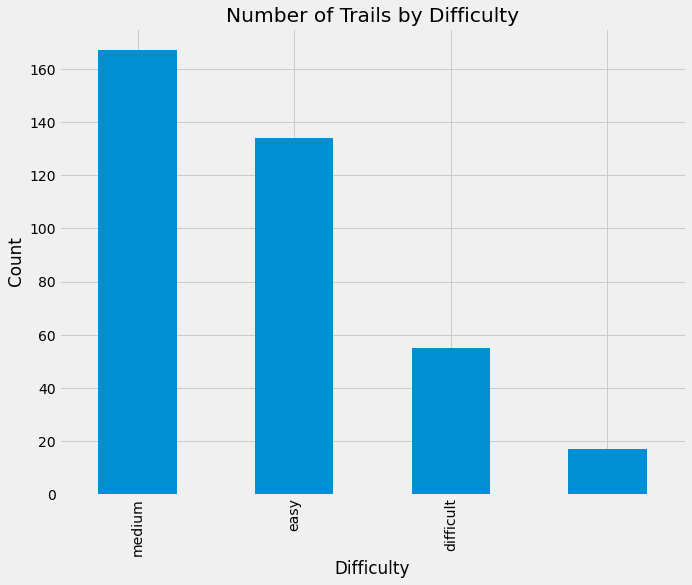

In [110]:
hikes_analysis['difficulty'].value_counts().plot(kind='bar')
plt.title('Number of Trails by Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Count')

### 3.4 Scatter Plot Visualization

The scatter plot paints an interesting picture of the trail data. First, the cycling trails are both the longest and the ones with most height meter difference out of the bunch. And second, it looks like all of the hiking trails fall between 2 and 20km. Perhaps this is because "Long distance hiking trails" are considered to be trails that are > 20km?

Text(0.5, 1.0, 'Length and Distance By Sport Type')

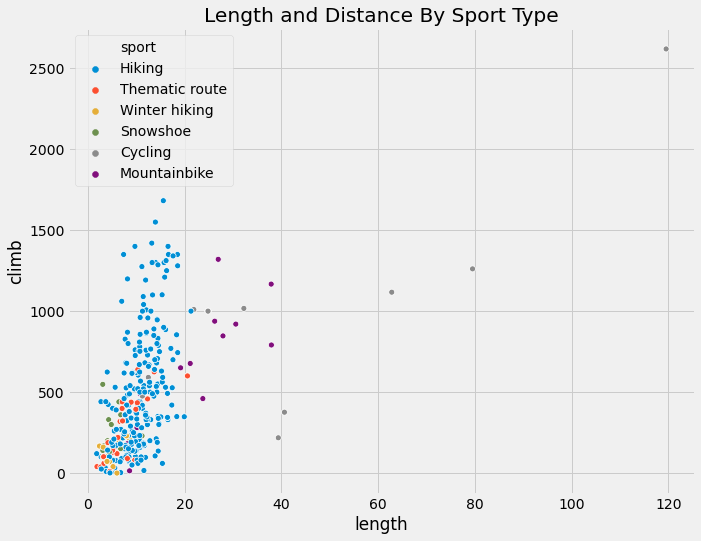

In [90]:
sns.scatterplot(    
    data=hikes_analysis,
    x="length", y="climb", hue='sport',
).set_title('Length and Distance By Sport Type');

In [30]:
# mean length for difficulty:
hikes_df.groupby('difficulty').mean()

,length,climb,min,max,technique,fitness
difficulty,,,,,,
,10.432941,298.235294,742.823529,1051.823529,0.000000,0.000000
difficult,22.358182,1116.196970,1012.045455,1885.151515,3.257576,5.000000
easy,7.947226,213.700730,833.306569,1055.510949,1.445255,1.846715
medium,12.208000,546.261111,1024.222222,1557.533333,2.655556,3.233333


### 3.5 Line Plot Visualization  

Trail Distance and elevation for all sports

Most of the trails in this data are quite high (around 1500m!) and vary from 20 to 80km. If 80km seems like a long hike, that's because it is! This lineplot is comparing the distance and height for all sports. It looks like we need to remove the other types of sports to get a better picture of hiking trails.

# Question SD: I'm not sure I understand the comment above. I believe most of the trails are below 1500m and below 20km.

# To Do SD: can we paint the different trails in different colors?

Text(0.5, 1.0, 'All Sports')

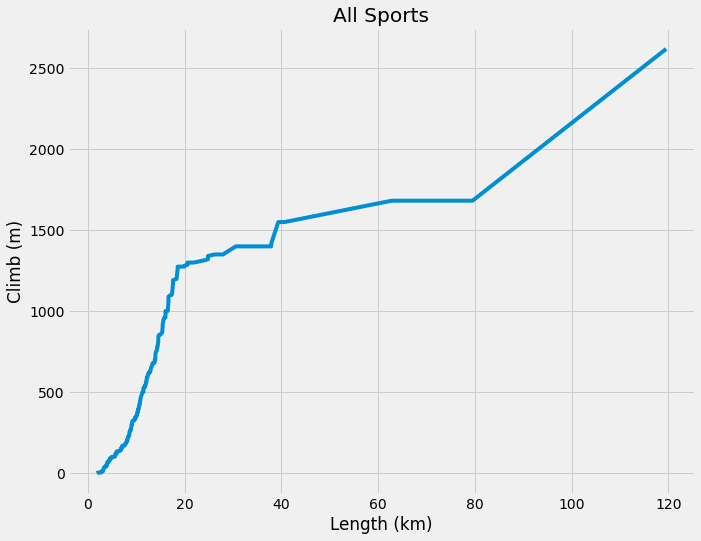

In [205]:
tour_len = sorted(pd.Series(hikes_analysis["length"]))
tour_climb = sorted(pd.Series(hikes_analysis["climb"]))
plt.plot(tour_len, tour_climb)
plt.ylabel('Climb (m)')
plt.xlabel("Length (km)")
plt.title('All Sports');

Now let's explore the data using only hiking trail data. 
The below graph makes a lot more sense than the one above, considering the maximum length is 20km instead of 80km 

In [ ]:
hiking = hikes_df[hikes_df.sport == "Hiking"]

Text(0.5, 1.0, 'Hikes')

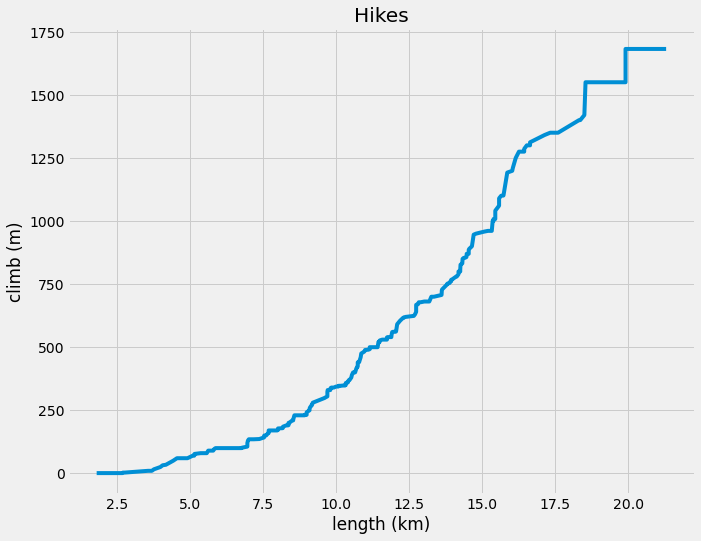

In [204]:
tour_len = sorted(pd.Series(hiking["length"]))
tour_climb = sorted(pd.Series(hiking["climb"]))
plt.plot(tour_len, tour_climb)
plt.ylabel('Climb (m)')
plt.xlabel("Length (km)")
plt.title('Hikes');

# 4 Analysis: Hiking Trails 

The primary interest of this analysis is hiking trail data. The following analysis will compare only hiking trails and drop the rest of the sport types.

### 4.1 Comparison: Average Trail Length vs. Fitness Score

The following dataframe uses the fitness scores and compares them to the length of each trail. How correlated is the trail length to the fitness score? New columns are added for average length, weighted length and normalized weighted length have been added. 

# explain why weighted ave lenght and norm. w.a. is needed

In [98]:
# calculating the count by Fitness level and the average length 
fitness_length = hiking.groupby('fitness') \
       .agg({'fitness':'count', 'length':'mean'}) \
       .rename(columns={'fitness':'count','length':'average_length'}) \
       .reset_index()

# calculating weighted and normalized length
fitness_length['weighted_ave_length'] = fitness_length["count"] * fitness_length["average_length"]
fitness_length["normalized_weighted_length"] = (fitness_length["weighted_ave_length"] - fitness_length["weighted_ave_length"].min()) \
                                                / (fitness_length["weighted_ave_length"].max() - fitness_length["weighted_ave_length"].min()) * 10
fitness_length

,fitness,count,average_length,weighted_ave_length,normalized_weighted_length
0,0,17,10.432941,177.36,2.022438
1,1,11,4.591818,50.51,0.407111
2,2,92,8.737283,803.83,10.000000
3,3,62,11.927097,739.48,9.180558
4,4,52,12.838846,667.62,8.265482
5,5,40,13.906250,556.25,6.847279
6,6,1,18.540000,18.54,0.000000


### 4.2 Line Plot: Length vs Fitness Rating
# Question, do we want to keep this?

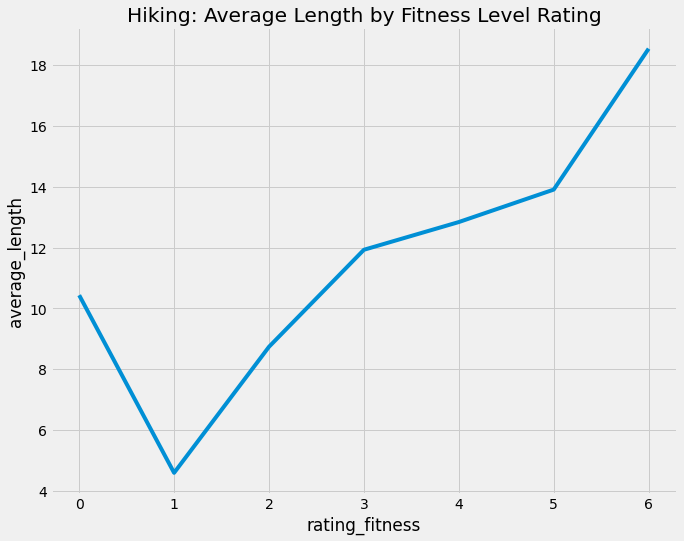

In [100]:
#--> Conclusion: the routes with no fitness rating seems quite long. Investigate further
plt.plot(fitness_length["fitness"], fitness_length["average_length"])
plt.ylabel('average_length')
plt.xlabel("rating_fitness")
plt.title('Hiking: Average Length by Fitness Level Rating')

plt.show()

### 4.3 Boxplots: Difficulty vs. Elevation Gain and Distance

The following boxplots show how the trail data is distributed by difficulty catagory compared to both elevation gain and distance. It's pretty clear that the relationship between elevation gain and difficulty is more meaningful than the relationship between distance and difficulty. My legs agree! 

# CHANGED the interpretation (SD). I find climb/elevation gain is clearer distinguishing the difficulty level. OK for you?

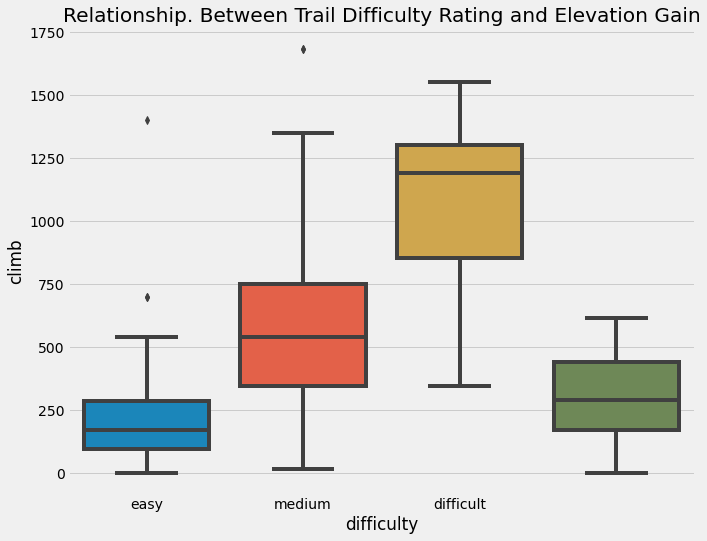

In [202]:
ax = sns.boxplot(x="difficulty", y="climb", data=hiking) \
.set_title('Relationship. Between Trail Difficulty Rating and Elevation Gain')


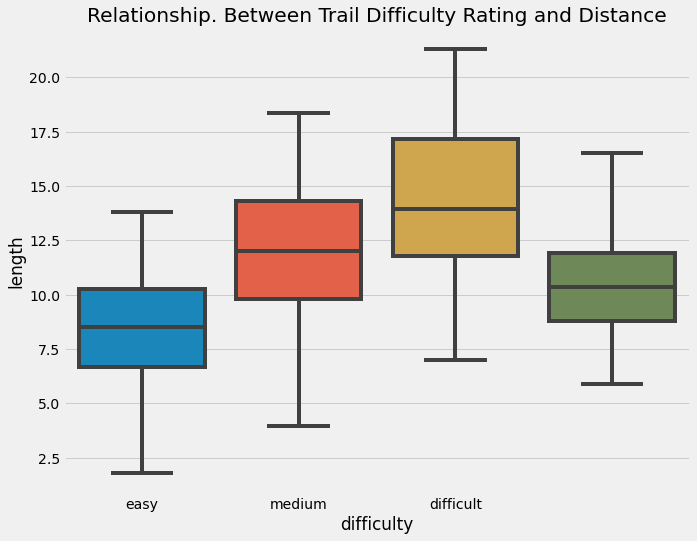

In [201]:
ax = sns.boxplot(x="difficulty", y="length",showfliers = False, data=hiking) \
.set_title('Relationship. Between Trail Difficulty Rating and Distance')


# 5 Download Trail GPS Data

The next part of this notebook deals with parsing HTML tags again, however this time around we will be gathering the GPS data needed to create the snowfall alert. The GPS data for each trail is actually a list of GPS points that comprise the length of the trail, from start to summit. However, we will only be using the first GPS point in our algorithm, which is the trail-head. 

The Bergfex website embedds their GPS data into downloadable files, which are meant to be uploaded to a GPS device for navigation purposes. As such, the following code will automatically download each GPS file into a folder. Importantly, a sleep timer is added to replicate how a human may download these files, if the sleep timer is not added, the website will become suspicious and prevent us from downloading more files. 

The type of GPS file that is being downloaded is a "KML" or "Keyhole Markup Language" file, which is a special type of XML file that can be read into google earth/google maps. For testing purposes, these KML files were uploaded into Google Earth, and it correctly displayed the location. 

- https://www.bergfex.com/downloads/gps/?type=&id=271548&fileType=kml


### 5.1 Download Batches of GPS Files

This loop uses the hike id's to navigate to each of the hike's pages. It then downloads the GPS file to the folder "gpx_files" and saves it as a filename "Unique hike id.gpx". To prevent being blocked from the page, we download the dat in small batches for all 400 activities.

In [116]:
import time
# create a small subset of data for testing
test_loop = final_id.iloc[20:30]
for sport_id in test_loop: 
    url_id = f"https://www.bergfex.com/downloads/gps/?type=&id={sport_id};fileType=kml"
    print(url_id)
    r = requests.get(url_id, allow_redirects=True)
    time.sleep(5) 
    write_link = (sport_id + ".gpx")
    # Replace kml files with your filename
    with open('gpx_files_23_Dec/'+ write_link, 'wb') as f:
        f.write(r.content)
    #open(write_link, 'wb').write(r.content)


https://www.bergfex.com/downloads/gps/?type=&id=162900;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=131695;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=49227;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=298943;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=50255;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=658328;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=508350;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=51008;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=508334;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=508331;fileType=kml


###  5.2 Extract Coordinates from GPX files

Now that the GPX files have been downloaded to a local file, we can loop through them and extract the important information, which is the latitude and the longitude of the trail start.

In [179]:
list_of_trails_list = []
list_of_files = glob.glob('gpx_files_23_Dec/*gpx')  
for fname in list_of_files:
    trail_gps_list = []
    gpx = gpxpy.parse(open(fname, 'r'))
    # parse out trail id
    remove_gpx = '.gpx'
    fname = fname.strip(remove_gpx)
    trail_id = fname.split('/')
    trail_id = trail_id[1]
    trail_gps_list.append(trail_id)
    for track in gpx.tracks: 
        trail_name = track.name
        trail_gps_list.append(trail_name)
        for segment in track.segments: 
            for point in segment.points: 
              lat = point.latitude
              trail_gps_list.append(lat)
              lon = point.longitude
              trail_gps_list.append(lon) 
              break
        list_of_trails_list.append(trail_gps_list)

print(list_of_trails_list)

[['508334', 'Ins urtümliche Gasteretal', 46.457939, 7.650267], ['50255', 'Vom Teuffenthal ins Eriz – idyllische Wanderung durch die Hügelwelt', 46.787262, 7.739526], ['162900', '"I gloube i gange no meh a Louenesee"', 46.439972, 7.292573], ['508331', 'Zur Rabeflue', 46.763229, 7.664105], ['131695', 'Wildhornhütte - Niesehore - Wildhornhütte', 46.37936, 7.38781], ['508350', 'Das Guggershorn – ein klassisches Ausflugsziel', 46.783642, 7.320042], ['658328', 'Durchs Jahr wandern - Wiehnachtswäg Aeschi', 46.650723, 7.710411], ['49227', 'Wald-, Alp- und Wasserreichtum im Schallenberg-Gebiet', 46.854221, 7.741203], ['51008', 'Auf dem Kientaler «Guggerwäg»', 46.579948, 7.708522], ['298943', 'Wildrosen Wanderung', 46.598392, 7.502433]]


### 5.3  Create a Dataframe and Save as CSV

Lets take a look at our data now that it has been extracted. It looks like everything has is working as intended. Each trail has a unique ID and latitude and longitude. This data can now be saved to a CSV file which will be used for the snow alert in the next notebook. 

In [184]:
trail_coords_df = pd.DataFrame(list_of_trails_list)
# name the columns
trail_coords_df.columns=['trail_id', 'name', 'lat', 'lon']
trail_coords_df.set_index('trail_id')

,name,lat,`lon
trail_id,,,
508334,Ins urtümliche Gasteretal,46.457939,7.650267
50255,Vom Teuffenthal ins Eriz – idyllische Wanderun...,46.787262,7.739526
162900,"""I gloube i gange no meh a Louenesee""",46.439972,7.292573
508331,Zur Rabeflue,46.763229,7.664105
131695,Wildhornhütte - Niesehore - Wildhornhütte,46.379360,7.387810
508350,Das Guggershorn – ein klassisches Ausflugsziel,46.783642,7.320042
658328,Durchs Jahr wandern - Wiehnachtswäg Aeschi,46.650723,7.710411
49227,"Wald-, Alp- und Wasserreichtum im Schallenberg...",46.854221,7.741203
51008,Auf dem Kientaler «Guggerwäg»,46.579948,7.708522


In [189]:
trail_coords_df.to_csv('trail_coords_df.csv', index=False)
read= pd.read_csv('trail_coords_df.csv')
read

,trail_id,name,lat,`lon
0,508334,Ins urtümliche Gasteretal,46.457939,7.650267
1,50255,Vom Teuffenthal ins Eriz – idyllische Wanderun...,46.787262,7.739526
2,162900,"""I gloube i gange no meh a Louenesee""",46.439972,7.292573
3,508331,Zur Rabeflue,46.763229,7.664105
4,131695,Wildhornhütte - Niesehore - Wildhornhütte,46.379360,7.387810
5,508350,Das Guggershorn – ein klassisches Ausflugsziel,46.783642,7.320042
6,658328,Durchs Jahr wandern - Wiehnachtswäg Aeschi,46.650723,7.710411
7,49227,"Wald-, Alp- und Wasserreichtum im Schallenberg...",46.854221,7.741203
8,51008,Auf dem Kientaler «Guggerwäg»,46.579948,7.708522
9,298943,Wildrosen Wanderung,46.598392,7.502433
